In [1]:
import pandas as pd
import os
from datetime import datetime as dt
import wrangle
import re
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (12,10)
alpha =.05

### Acquire 

In [2]:
df = wrangle.get_combined_df()
df.head()

,ercot_load,dow,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,...,vc_precip,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00-06:00,7931.241900,Friday,1,1,47.3,41.2,43.2,85.37,0.0,27.5,...,0.0,24.2,16.1,360.0,1027.7,98.7,9.9,0.0,NaN,0
2010-01-01 01:00:00-06:00,7775.456846,Friday,1,1,46.8,39.9,41.4,81.38,0.0,24.2,...,0.0,26.5,15.1,350.0,1028.1,98.6,9.9,0.0,NaN,0
2010-01-01 02:00:00-06:00,7704.815982,Friday,1,1,45.0,37.1,39.6,81.24,0.0,28.9,...,0.0,31.1,21.9,350.0,1028.8,98.6,9.9,0.0,NaN,0
2010-01-01 03:00:00-06:00,7650.575724,Friday,1,1,45.0,38.3,39.3,80.35,0.0,26.4,...,0.0,25.4,17.2,350.0,1028.9,98.7,9.9,0.0,NaN,0
2010-01-01 04:00:00-06:00,7666.708317,Friday,1,1,45.0,37.7,37.8,75.72,0.0,NaN,...,0.0,32.3,24.2,10.0,1028.0,27.7,9.9,0.0,NaN,0


### Prepare

In [3]:
df['hour'] = df.index.strftime('%H')

In [4]:
# split data into train and test datasets, train 2010-2017 and test 2018-2022

train = df[:'2017']
test = df['2018':]

In [5]:
train.describe()

,ercot_load,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,hs_windspeed,...,vc_precip,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex
count,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000,13765.000000,70128.000000,...,70128.000000,20699.000000,70128.000000,70128.000000,70062.000000,70128.000000,70128.000000,70128.000000,37860.000000,70128.000000
mean,11061.473113,0.713895,0.027379,71.252129,72.399886,59.365617,69.410485,0.003719,22.458896,7.962128,...,0.003252,23.027924,9.095980,151.728505,1016.142886,39.257454,8.612835,216.765616,1.444847,2.157854
std,2590.744768,0.451942,0.163185,13.889405,16.751161,15.251368,20.057911,0.038717,5.194451,4.895214,...,0.033001,6.841198,5.548535,102.409535,5.734598,41.848493,2.383467,293.859915,1.055741,2.951228
min,6293.573072,0.000000,0.000000,20.300000,4.300000,1.800000,10.050000,0.000000,11.400000,0.000000,...,0.000000,0.000000,0.000000,0.000000,993.900000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9191.267527,0.000000,0.000000,62.700000,62.700000,49.800000,54.470000,0.000000,18.300000,4.900000,...,0.000000,19.500000,5.100000,73.000000,1012.500000,0.000000,8.200000,0.000000,0.500000,0.000000
50%,10466.756159,1.000000,0.000000,73.500000,73.500000,64.500000,73.160000,0.000000,21.600000,7.700000,...,0.000000,22.900000,8.100000,149.000000,1015.400000,25.900000,9.900000,8.900000,1.400000,0.000000
75%,12476.718905,1.000000,0.000000,80.700000,85.200000,71.700000,86.620000,0.000000,25.300000,10.900000,...,0.000000,26.400000,12.700000,189.000000,1019.100000,88.300000,9.900000,415.800000,2.300000,4.000000
max,20100.758612,1.000000,1.000000,110.400000,115.900000,80.300000,100.000000,1.880000,83.900000,36.800000,...,1.850000,161.100000,53.100000,360.000000,1042.500000,100.000000,74.200000,1079.000000,3.900000,10.000000


In [6]:
train.tail(1)

,ercot_load,dow,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,...,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2017-12-31 23:00:00-06:00,11579.853459,Sunday,0,0,40.8,33.0,30.2,65.5,0.0,25.7,...,26.1,14.9,360.0,1033.7,95.6,9.9,0.0,0.0,0,23


In [7]:
test.head(1)

,ercot_load,dow,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,...,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00-06:00,11452.163689,Monday,1,1,38.9,29.9,28.4,65.69,0.0,26.4,...,25.8,16.0,10.0,1033.9,98.8,9.9,0.0,0.0,0,00


In [8]:
test.tail(1)

,ercot_load,dow,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,...,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-30 23:00:00-05:00,14065.386852,Thursday,1,0,77.2,77.2,73.4,88.06,0.0,10.5,...,13.9,7.0,79.0,1014.0,0.4,9.9,0.0,NaN,0,23


### Explore

### Initial look at the target variable

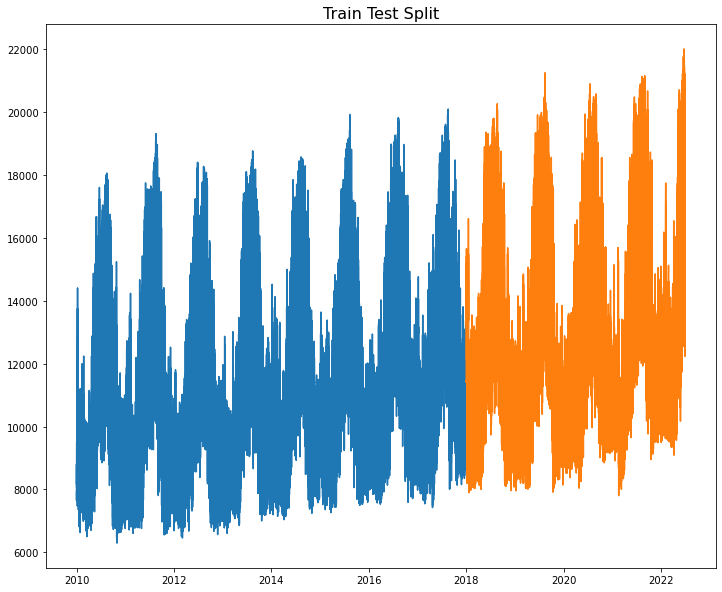

In [9]:
plt.plot(train.index, train.ercot_load)
plt.plot(test.index, test.ercot_load)
plt.title('Train Test Split', fontsize = 16)
plt.show()

In [10]:
def subgroups():
    weekday = train[train.is_weekday== 1]
    weekend = train[train.is_weekday== 0]
    saturday = train[train.dow=='Saturday']
    sunday = train[train.dow=='Sunday']
    holidays = train[train.is_obs_holiday==1]
    not_holiday = train[train.is_obs_holiday==0]
    return weekday, weekend, saturday, sunday, holidays, not_holiday

In [11]:
weekday, weekend, saturday, sunday, holidays, not_holiday = subgroups()

In [12]:
def plot_resample():
    train.resample('H').ercot_load.mean().plot(alpha=.5, label='Hourly')
    train.resample('D').ercot_load.mean().plot(alpha=.5, label='Daily')
    train.resample('W').ercot_load.mean().plot(alpha=.8, label='Weekly')
    train.resample('M').ercot_load.mean().plot(label='Montly')
    train.resample('Y').ercot_load.mean().plot(label='Yearly')
    plt.legend()
    plt.show()

**Notes:** Seasonality is visible, with an increase in ercot load over time.

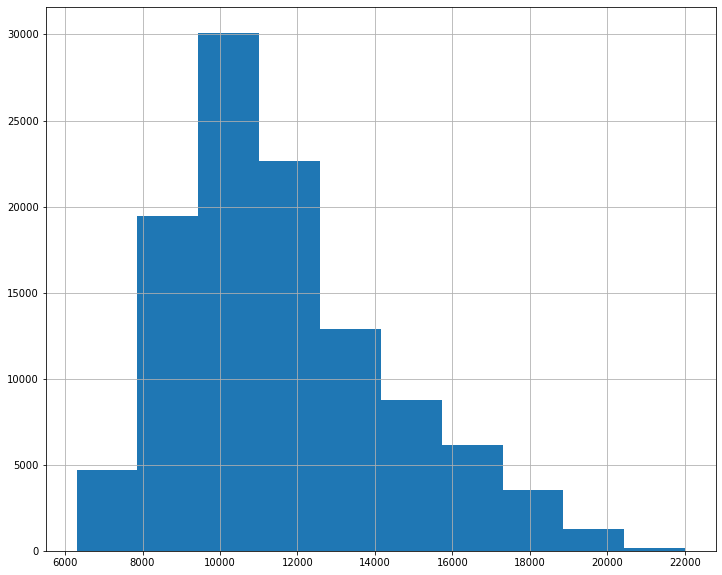

In [13]:
df.ercot_load.hist()
plt.show()

### Inital Hypotheses:
   - There is a relationship between the day of the week and energy demand.
       - Compare ercot load per each day of the week.
       - Compare ercot load per weekend or weekday.
       - Compare Saturday and Sunday.
   - There is a relationship between the time of day and energy demand.
   - There is a relationship between holidays and energy demand.
       - Compare ercot load per each day of the week, when it is an observed holiday.

###  Compare ercot load per each day of the week.

In [14]:
# ax = train.groupby(train.dow).ercot_load.mean().plot.bar(width=.9, ec='black')
# plt.xticks(rotation=0)
# ax.set(title='Average Load by Day of the Week', xlabel='', ylabel='Megawatts')
# plt.show()

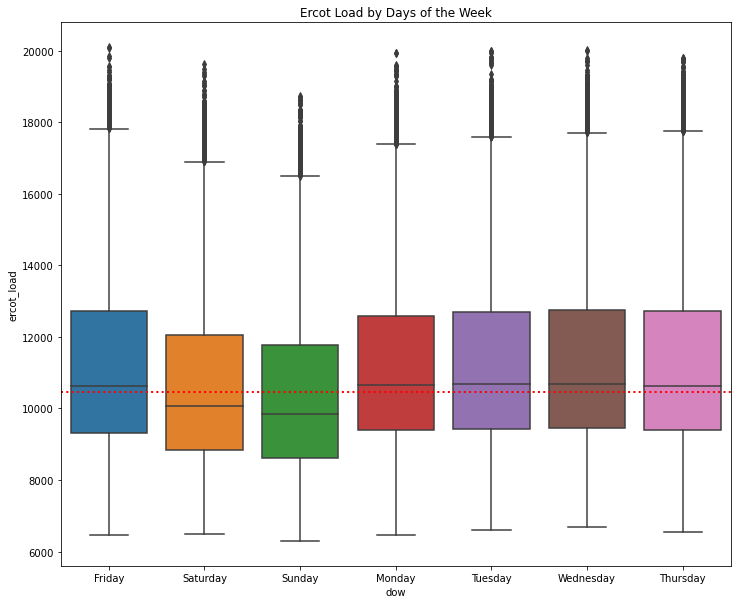

In [15]:
sns.boxplot(x = 'dow', y = 'ercot_load', data=train) 
plt.axhline(train.ercot_load.median(),ls= ':', color = 'red', linewidth=2)
plt.title('Ercot Load by Days of the Week')
plt.show()

### Hypothesis Testing

In [16]:
def days_of_week():
    monday = train[train.dow=='Monday'].ercot_load
    tuesday = train[train.dow=='Tuesday'].ercot_load
    wednesday = train[train.dow=='Wednesday'].ercot_load
    thursday = train[train.dow=='Thursday'].ercot_load
    friday = train[train.dow=='Friday'].ercot_load
    saturday = train[train.dow=='Saturday'].ercot_load
    sunday = train[train.dow=='Sunday'].ercot_load
    return monday, tuesday, wednesday, thursday, friday, saturday, sunday

In [17]:
monday, tuesday, wednesday, thursday, friday, saturday, sunday = days_of_week()

#### Perform Levene's Test for Equal Variance
- Null Hypothesis: Variance is equal between the days of the week.
- Alternative Hypothesis: Variance is not equal between the days of the week.

In [18]:
stat, p = stats.levene(monday,tuesday,wednesday,thursday,friday,saturday,sunday)

In [19]:
p

4.198650539667989e-10

In [20]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


#### Perform Kruskal- Wallis Test to determine significant difference between ercot load and the day of the week.
 - Kruskal-Wallis test performed as variance is not equal.
 
- Null Hypothesis: The mean of ercot load is equal on every day of the week.
- Alternative Hypothesis: The mean of ercot load is not equal for each day of the week.

In [21]:
stat, p = stats.kruskal(monday,tuesday,wednesday,thursday,friday,saturday,sunday)
stat, p

(1338.202452707832, 5.811407864502267e-286)

In [22]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


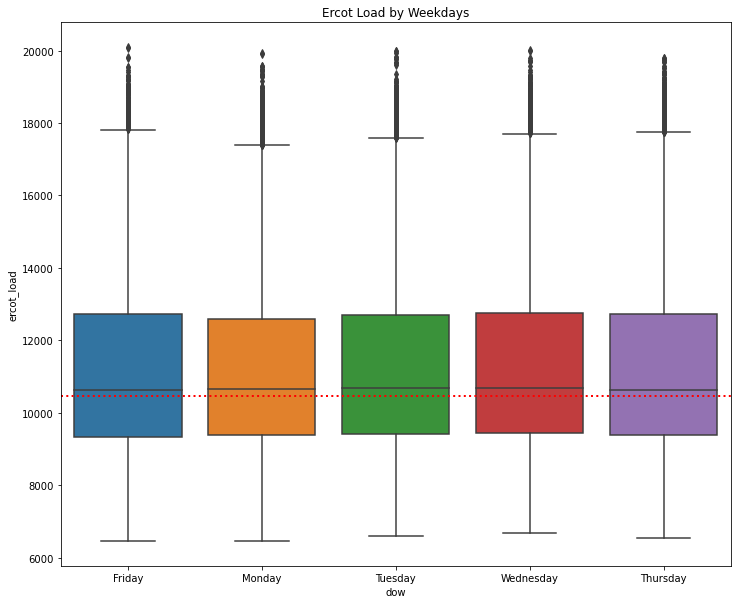

In [23]:
sns.boxplot(x = 'dow', y = 'ercot_load', data=weekday) 
plt.axhline(train.ercot_load.median(),ls= ':', color = 'red', linewidth=2)
plt.title("Ercot Load by Weekdays")
plt.show()

#### Perform Levene's Test for Equal Variance
- Null Hypothesis: Variance is equal between weekdays.
- Alternative Hypothesis: Variance is not equal between weekdays.

In [24]:
stat, p = stats.levene(monday,tuesday,wednesday,thursday,friday)
p

0.5247928754629405

In [25]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We fail to reject the null hypothesis


#### Perform ANOVA Test to determine significant difference between ercot load and the day of the week.
 
- Null Hypothesis: The mean of ercot load is equal on every weekday.
- Alternative Hypothesis: The mean of ercot load is not equal on every weekday.

In [26]:
stat, p = stats.f_oneway(monday,tuesday,wednesday,thursday,friday)
stat, p

(2.162150513586479, 0.0705251155472521)

In [27]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We fail to reject the null hypothesis


###   Compare ercot load per weekend or weekday.

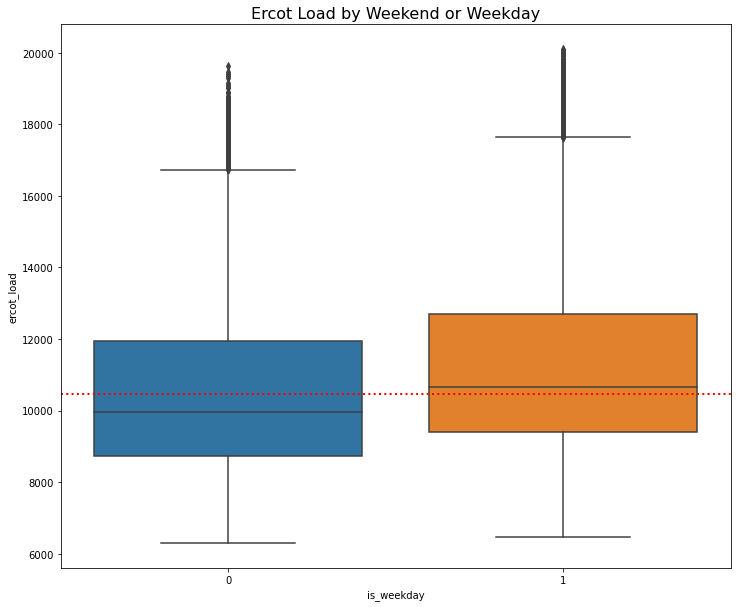

In [28]:
sns.boxplot(x = 'is_weekday', y = 'ercot_load', data=train) 
plt.title('Ercot Load by Weekend or Weekday', fontsize=16)
plt.axhline(train.ercot_load.median(),ls= ':', color = 'red', linewidth=2)
plt.show()

**Notes:** As visualized prior by each day of the week, Saturday and Sunday have a lower median ercot load than weekdays. 

### Hypothesis Testing

#### Perform Levene's Test to check for equal variance.
- Null Hypothesis: Variance is equal between weekdays and weekends.
- Alternative Hypothesis: Variance is not equal between weekdays and weekends.

In [29]:
stat, p = stats.levene(weekday.ercot_load, weekend.ercot_load)

In [30]:
p

3.722072198971905e-12

In [31]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [32]:
# weekday.ercot_load.hist(), weekend.ercot_load.hist()
# plt.show()

#### Perform Mann-Whitney's test to determine if ercot load is significantly different on weekends and weekdays.

- Null Hypothesis: Ercot load is equal on the weekends and weekdays.
- Alternative Hypothesis: Ercot load is not equal on the weekends and weekdays.

In [33]:
stat, p = stats.mannwhitneyu(weekday.ercot_load, weekend.ercot_load)
p

9.184955997063736e-279

In [34]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


#### Perform 1-tailed T-test to determine if weekday ercot load is significantly more than weekends.
- Null Hypothesis: Ercot load on the weekdays is <= ercot load on the weekends.
- Alternative Hypothesis: Ercot load on the weekdays is > ercot load on the weekends.

In [35]:
t, p = stats.ttest_ind(weekday.ercot_load, weekend.ercot_load, equal_var=False)
t, p / 2

(32.53508226695425, 2.1062869378056432e-229)

In [36]:
if p / 2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

We reject the Null Hypothesis


###   Compare Saturday and Sunday.

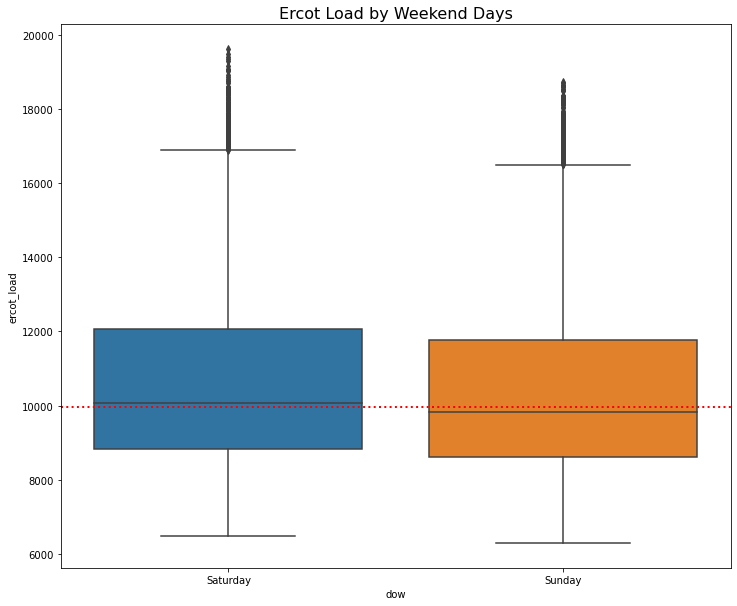

In [37]:
sns.boxplot(x = 'dow', y = 'ercot_load', data=weekend) 
plt.title('Ercot Load by Weekend Days', fontsize=16)
plt.axhline(weekend.ercot_load.median(),ls= ':', color = 'red', linewidth=2)
plt.show()

### Hypothesis Testing

#### Perform Levene's Test to check for equal variance.
- Null Hypothesis: Variance is equal between Saturday and Sunday.
- Alternative Hypothesis: Variance is not equal between Saturday and Sunday.

In [38]:
stat, p = stats.levene(saturday, sunday)

In [39]:
p

0.21707024044988293

In [40]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We fail to reject the null hypothesis


In [41]:
# saturday.ercot_load.hist(), sunday.ercot_load.hist()
# plt.show()

#### Perform Independent T-test to determine if ercot load on Saturday and Sunday are significantly different.
- Null Hypothesis: Ercot load is equal on Saturday and Sunday.
- Alternative Hypothesis: Ercot load is not equal on Saturday and Sunday.

In [42]:
stat, p = stats.ttest_ind(saturday, sunday)
p

4.020479887345446e-11

In [43]:
stat, p = stats.mannwhitneyu(saturday, sunday)
p

1.546919826909082e-14

In [44]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


#### Perform 1-tailed T-test to determine if Saturday ercot load is significantly more than Sunday.
- Null Hypothesis: Ercot load on the Saturday is <= ercot load on Sunday.
- Alternative Hypothesis: Ercot load on Saturday is > ercot load on Sunday.

In [45]:
t, p = stats.ttest_ind(saturday, sunday, equal_var=False)
t, p / 2

(6.606992920497449, 2.010241205380238e-11)

In [46]:
if p / 2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

We reject the Null Hypothesis


### Time of day:

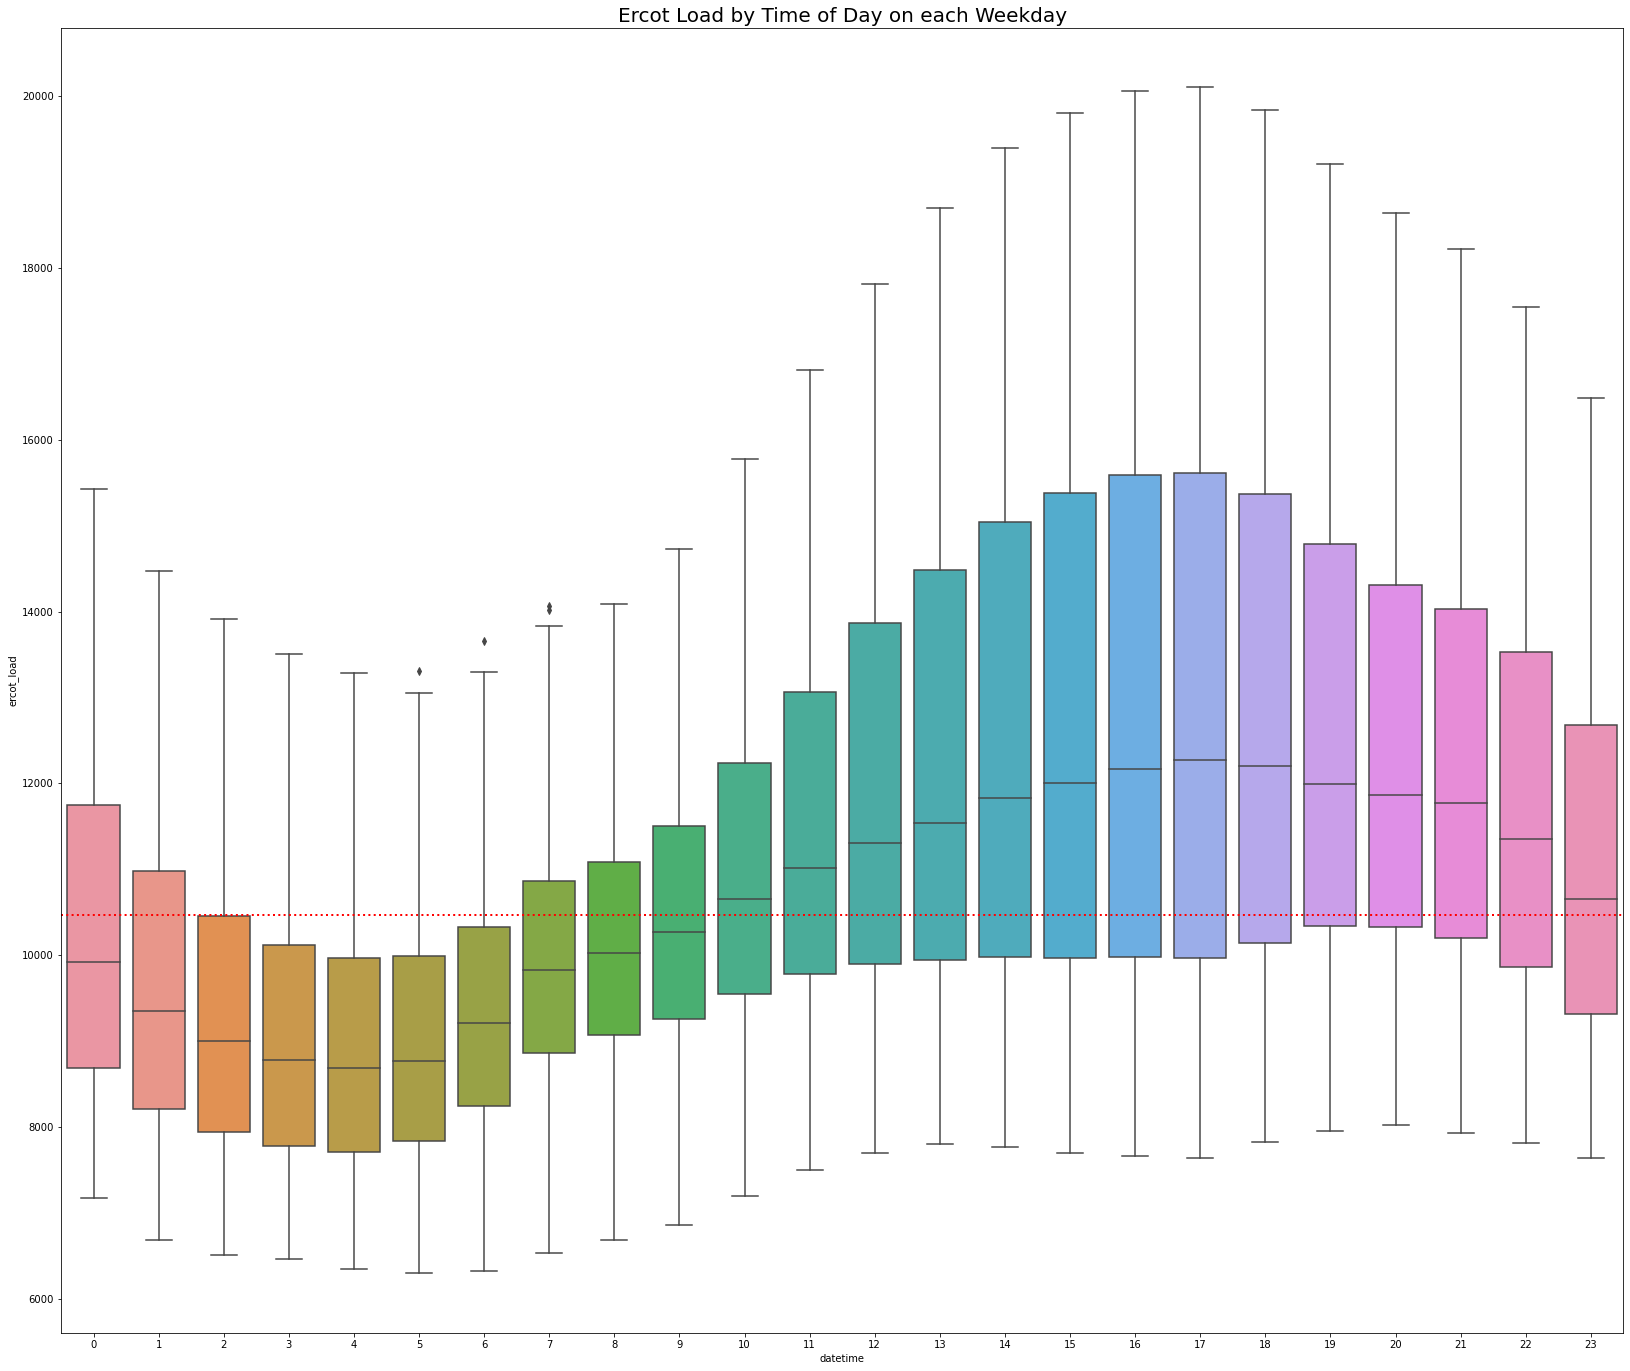

In [47]:
plt.figure(figsize=(28, 24))
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.boxplot(x = train.index.hour, y = 'ercot_load', data=train) 
plt.title('Ercot Load by Time of Day on each Weekday', fontsize=20)
plt.axhline(train.ercot_load.median(),ls= ':', color = 'red', linewidth=2)
plt.show()

**Notes:** There is a visible change in ercot load by hour, with a lull in the early hours of the day and an expected increase in afternoon. I expect this would be correlated with max temperatures. Another note: the hours of 05-07 have outliers on the side of increased ercot load.

In [48]:
def plot_hourly_ercot_load():
    plt.figure(figsize=(28, 24))
    order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    sns.boxplot(x = 'dow', y = 'ercot_load', data=train, hue='hour',order=order) 
    plt.title('Ercot Load by Time of Day on each Weekday', fontsize=20)
    plt.axhline(train.ercot_load.median(),ls= ':', color = 'red', linewidth=2)
    plt.show()

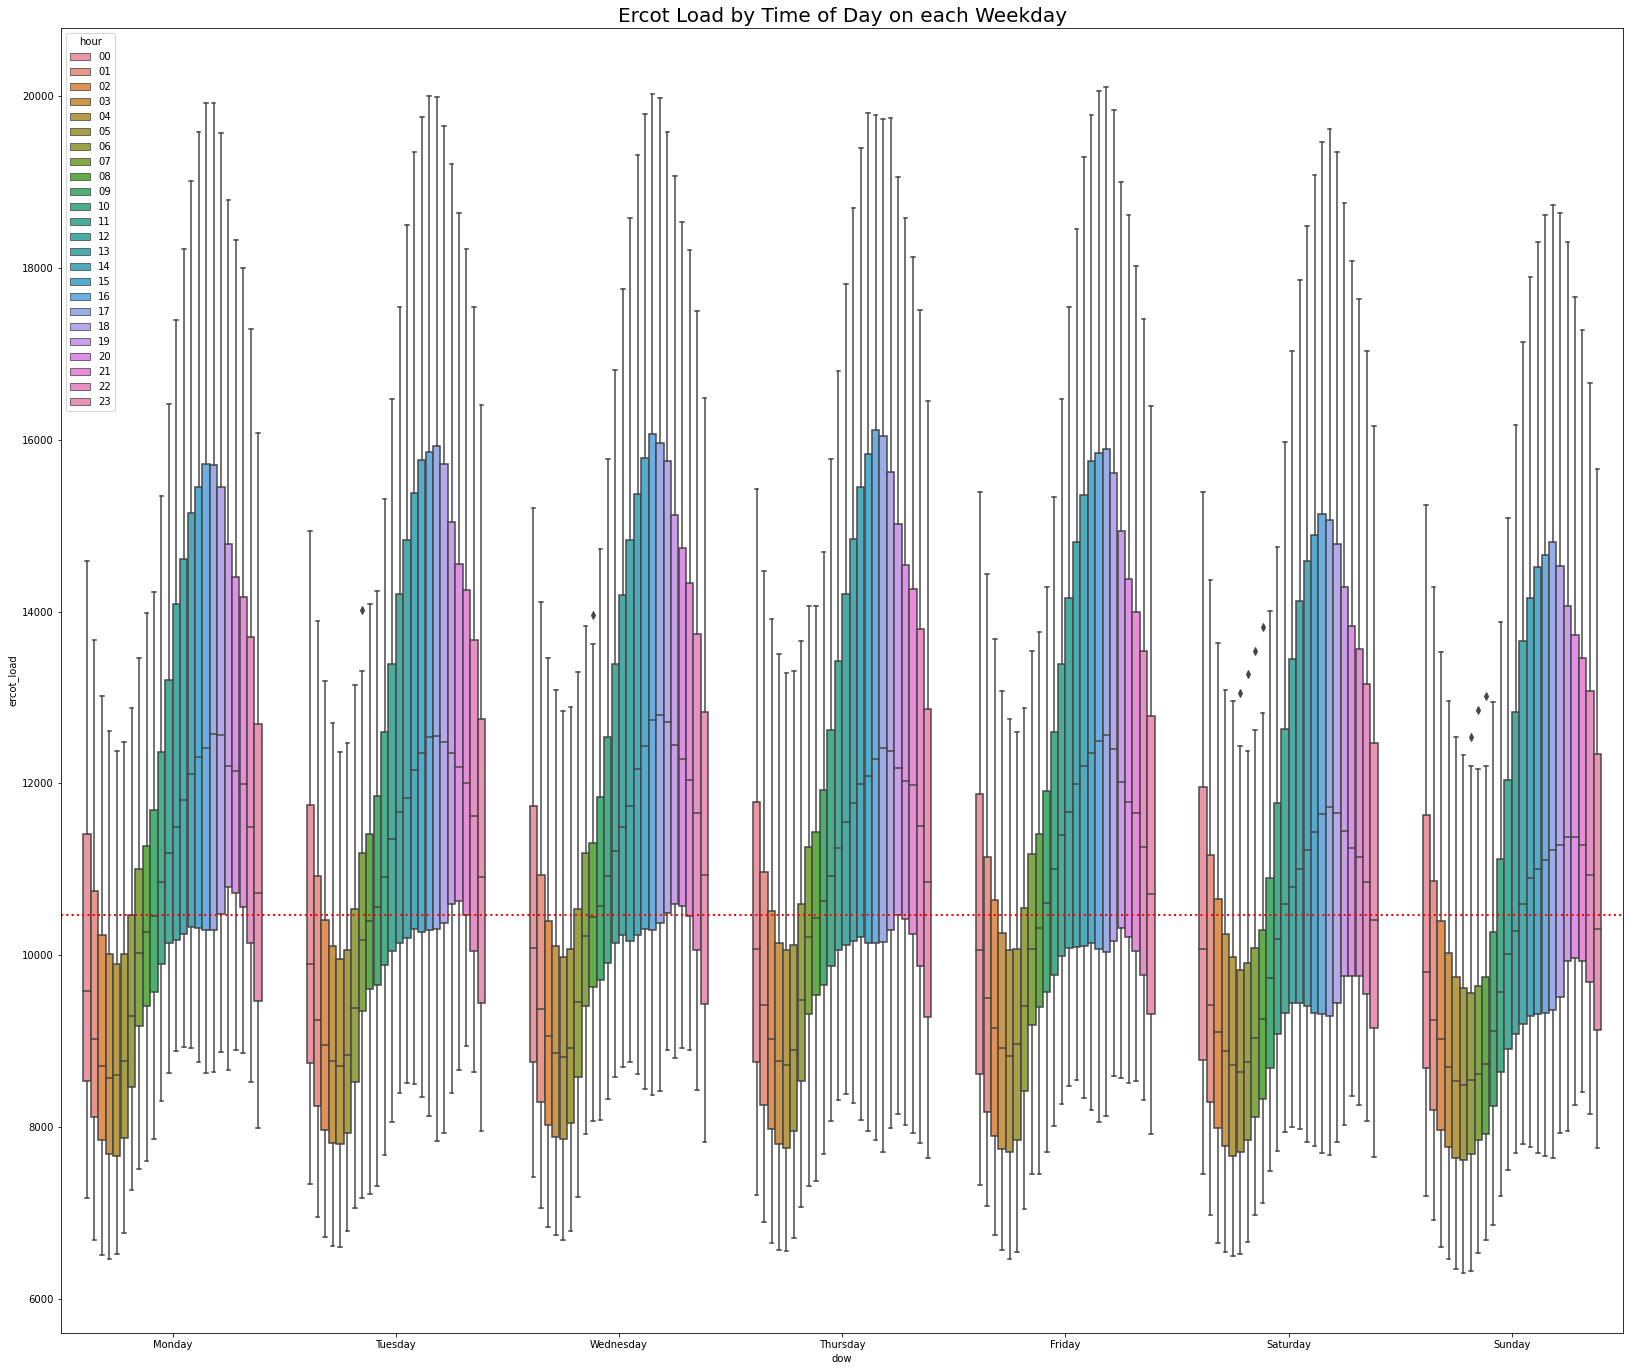

In [49]:
plot_hourly_ercot_load()

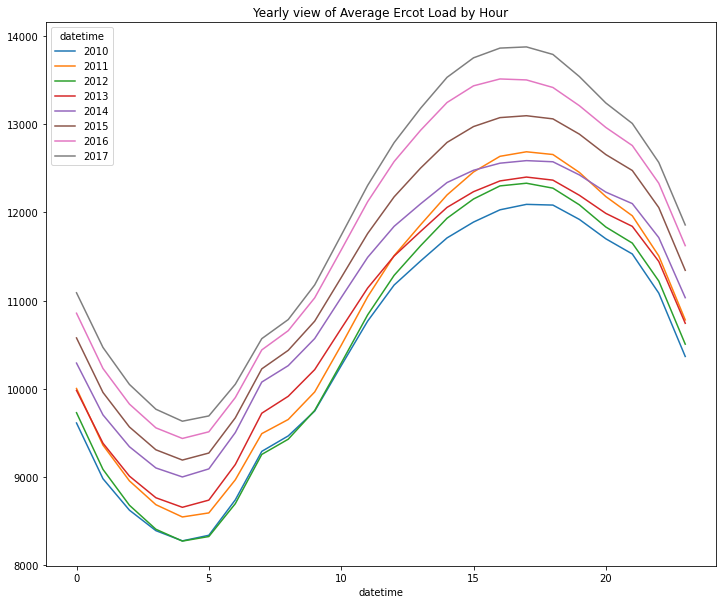

In [114]:
train.groupby([train.index.year, train.index.hour]).ercot_load.mean().unstack(0).plot(title='Yearly view of Average Ercot Load by Hour')
plt.show()

**Notes:** This visualization shows a similiar pattern that shown above, but also breaks out the time of day by year. We can see that in the early years, the ercot load was lower and has increased as time has passed, while still following the same daily trends.

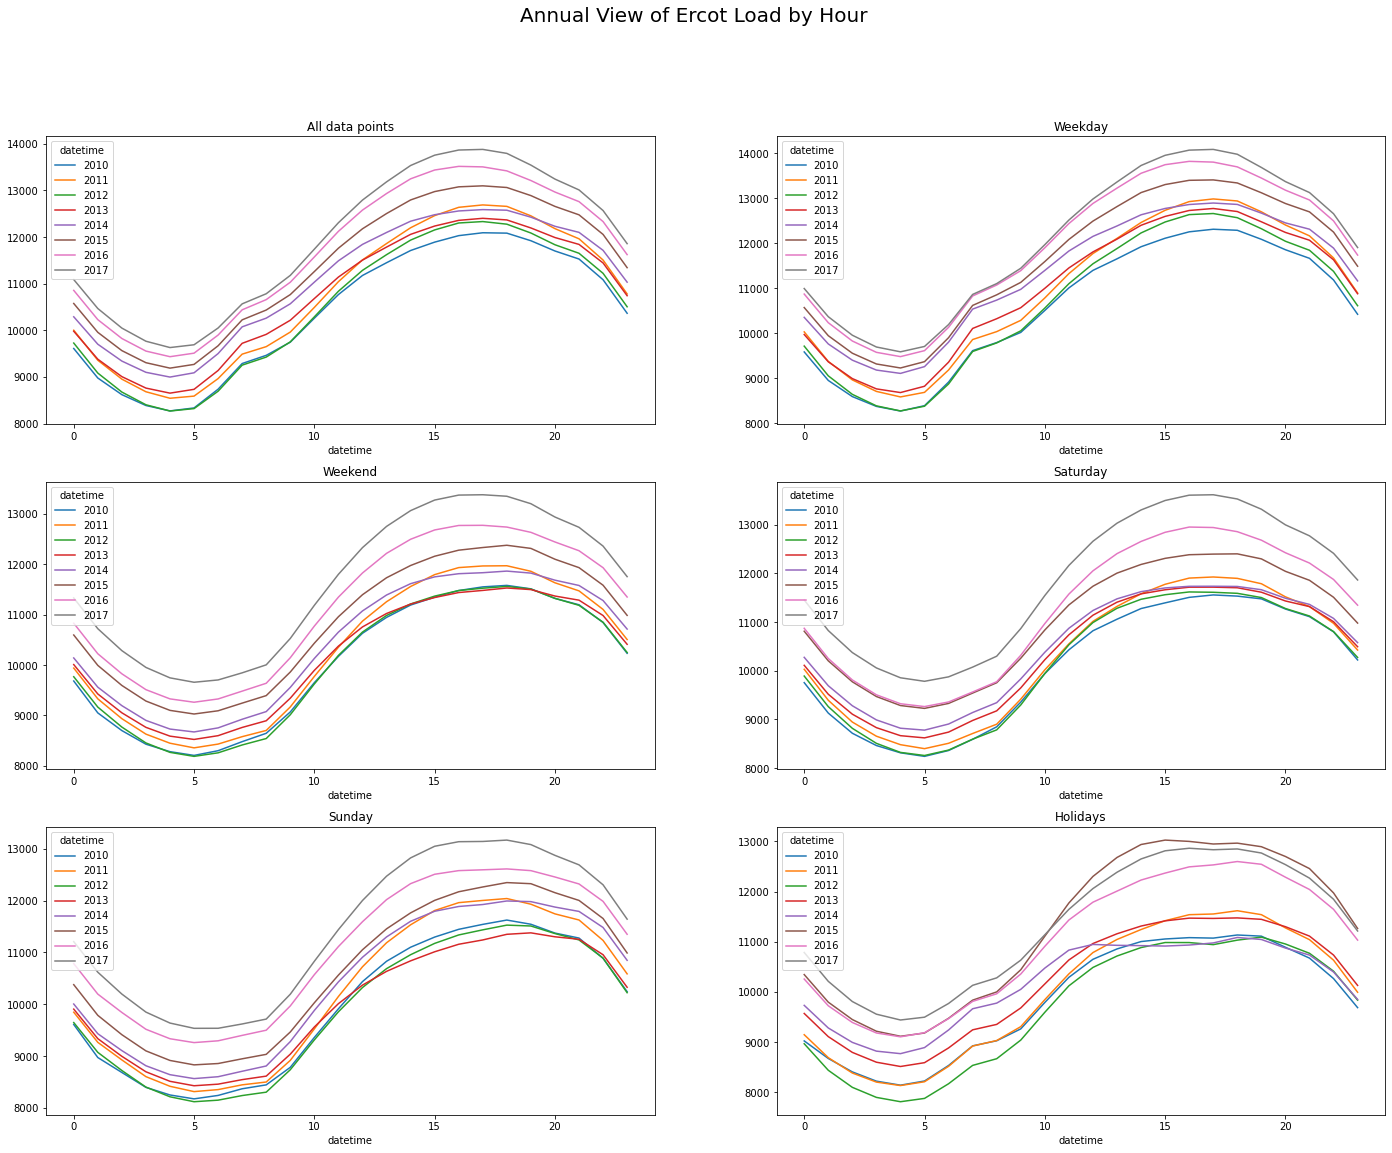

In [51]:
fig, axes = plt.subplots(3, 2, figsize=(24, 18))
fig.suptitle('Annual View of Ercot Load by Hour',fontsize=20)

train.groupby([train.index.year, train.index.hour]).ercot_load.mean().unstack(0).plot(ax=axes[0, 0],title='All data points')
weekday.groupby([weekday.index.year, weekday.index.hour]).ercot_load.mean().unstack(0).plot(ax=axes[0, 1],title='Weekday')
weekend.groupby([weekend.index.year, weekend.index.hour]).ercot_load.mean().unstack(0).plot(ax=axes[1, 0],title='Weekend')
saturday.groupby([saturday.index.year, saturday.index.hour]).mean().unstack(0).plot(ax=axes[1, 1],title='Saturday')
sunday.groupby([sunday.index.year, sunday.index.hour]).mean().unstack(0).plot(ax=axes[2,0],title='Sunday')
holidays.groupby([holidays.index.year, holidays.index.hour]).ercot_load.mean().unstack(0).plot(ax=axes[2,1],title='Holidays')
plt.show()

### Hypothesis Testing

#### Perform Levene's Test for Equal Variance
- Null Hypothesis: Variance is equal between the hours of the day.
- Alternative Hypothesis: Variance is not equal between the hours of the day.

In [52]:
def ercot_load_by_hour():
    zero = train[train.hour=='00'].ercot_load
    one = train[train.hour=='01'].ercot_load
    two = train[train.hour=='02'].ercot_load
    three = train[train.hour=='03'].ercot_load
    four = train[train.hour=='04'].ercot_load
    five = train[train.hour=='05'].ercot_load
    six = train[train.hour=='06'].ercot_load
    seven = train[train.hour=='07'].ercot_load
    eight = train[train.hour=='08'].ercot_load
    nine = train[train.hour=='09'].ercot_load
    ten = train[train.hour=='10'].ercot_load
    eleven = train[train.hour=='11'].ercot_load
    tweleve = train[train.hour=='12'].ercot_load
    thirteen = train[train.hour=='13'].ercot_load
    fourteen = train[train.hour=='14'].ercot_load
    fifteen = train[train.hour=='15'].ercot_load
    sixteen = train[train.hour=='16'].ercot_load
    seventeen = train[train.hour=='17'].ercot_load
    eighteen = train[train.hour=='18'].ercot_load
    nineteen = train[train.hour=='19'].ercot_load
    twenty = train[train.hour=='20'].ercot_load
    twentyone = train[train.hour=='21'].ercot_load
    twentytwo = train[train.hour=='22'].ercot_load
    twentythree = train[train.hour=='23'].ercot_load
    return zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, tweleve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree

In [53]:
zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, tweleve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree = ercot_load_by_hour() 

In [54]:
stat, p = stats.levene(zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, tweleve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree)

In [55]:
stat, p

(647.3097281228604, 0.0)

In [56]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


#### Perform Kruskal- Wallis Test to determine significant difference between ercot load and the hour of the day.
 - Kruskal-Wallis test performed as variance is not equal.
 
- Null Hypothesis: The mean of ercot load is equal during every hour of the day.
- Alternative Hypothesis: The mean of ercot load is not equal during every hour of the day.

In [57]:
stat, p = stats.kruskal(zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, tweleve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree)
p

0.0

In [58]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


### Holidays

In [59]:
train.is_obs_holiday.value_counts()

0    68208
1     1920
Name: is_obs_holiday, dtype: int64

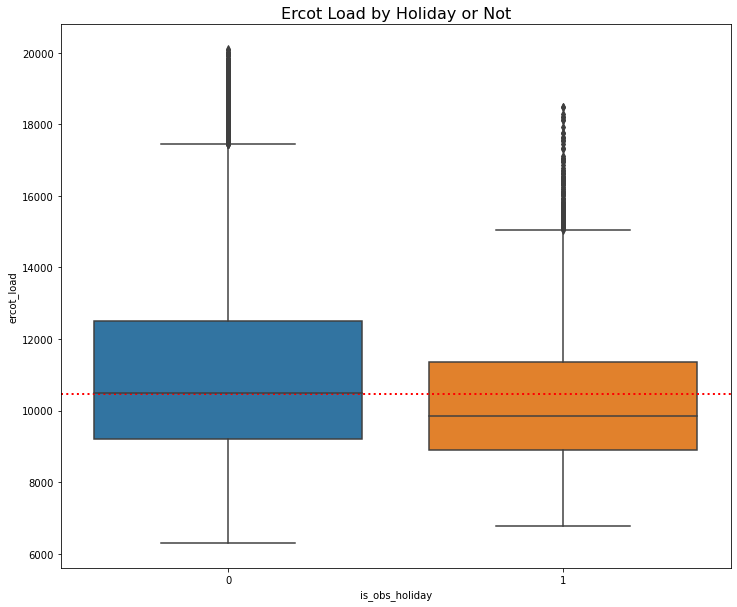

In [60]:
sns.boxplot(x = 'is_obs_holiday', y = 'ercot_load', data=train) 
plt.axhline(train.ercot_load.median(),ls= ':', color = 'red', linewidth=2)
plt.title('Ercot Load by Holiday or Not', fontsize=16)
plt.show()

**Notes:** Median ercot load value is less on holidays than non-holidays.

### Hypothesis Testing

#### Perform Levene's Test for Equal Variance
- Null Hypothesis: Variance is equal between holidays and non-holidays.
- Alternative Hypothesis: Variance is not equal between holidays and non-holidays.

In [61]:
stat, p = stats.levene(holidays.ercot_load, not_holiday.ercot_load)
p

5.324150479142653e-15

In [62]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [63]:
# holidays.ercot_load.hist(), not_holiday.ercot_load.hist()
# plt.show()

#### Perform Mann-Whitney's test to determine if ercot load is significantly different on holidays and non-holidays.

- Null Hypothesis: Ercot load is equal on holidays and non-holidays.
- Alternative Hypothesis: Ercot load is not equal on holidays and non-holidays.

In [64]:
stat, p = stats.mannwhitneyu(holidays.ercot_load, not_holiday.ercot_load)
p

7.55513284996125e-30

In [65]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


#### Perform 1-tailed T-test to determine if holiday ercot load is significantly less than non-holidays.
- Null Hypothesis: Ercot load on the holidays is >= ercot load on non-holidays.
- Alternative Hypothesis: Ercot load on holidays is < ercot load on non-holidays.

In [66]:
t, p = stats.ttest_ind(holidays.ercot_load, not_holiday.ercot_load, equal_var=False)
t, p / 2

(-11.905562288972295, 5.900597596324182e-32)

In [67]:
if p / 2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t > 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

We reject the Null Hypothesis


###  Compare weekdays depending on if the day is a holiday or not.
      

In [68]:
weekday_no_holiday = weekday[weekday.is_obs_holiday==0]
weekday_holiday = weekday[weekday.is_obs_holiday==1]

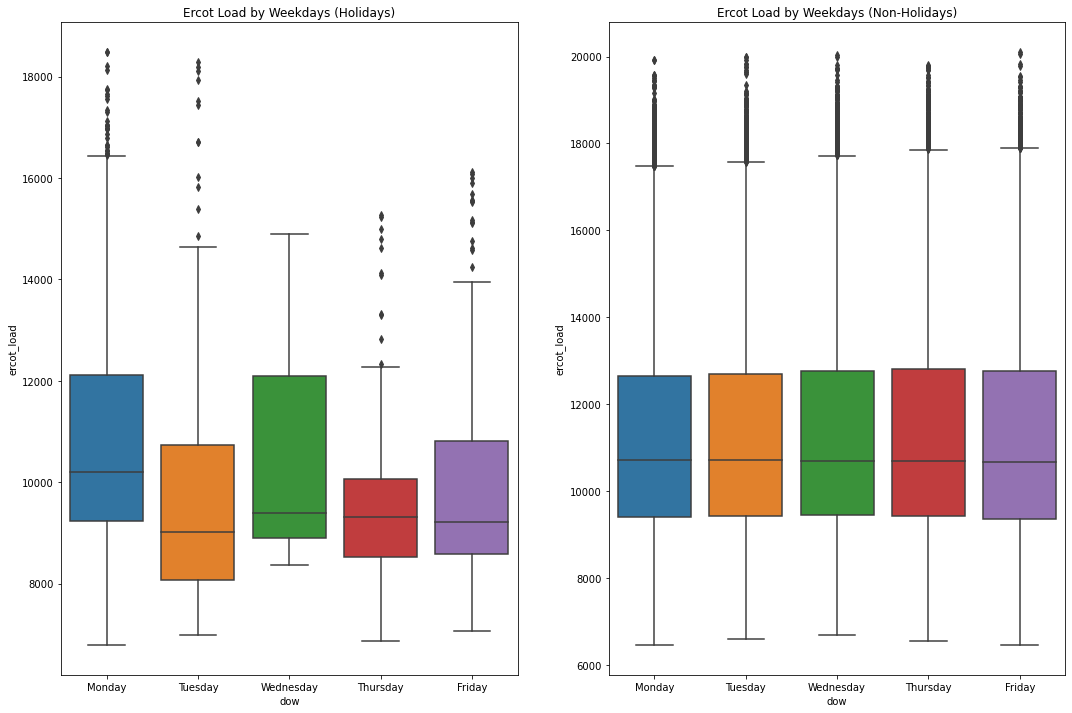

In [69]:
plt.figure(figsize = (18, 12))
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
plt.subplot(121)
sns.boxplot(x = 'dow', y = 'ercot_load', data=weekday_holiday, order=order) 
plt.title('Ercot Load by Weekdays (Holidays)')

plt.subplot(122)
sns.boxplot(x = 'dow', y = 'ercot_load', data=weekday_no_holiday, order=order) 
plt.title('Ercot Load by Weekdays (Non-Holidays)')
plt.show()

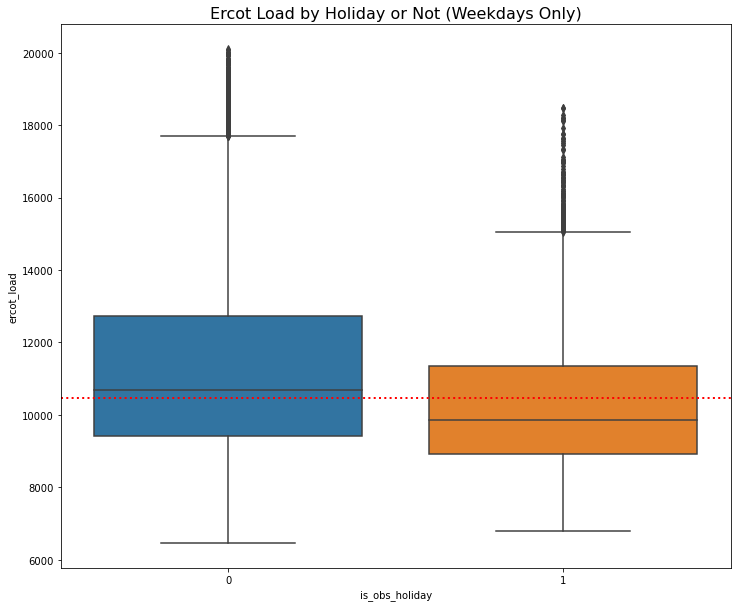

In [70]:
sns.boxplot(x = 'is_obs_holiday', y = 'ercot_load', data=weekday) 
plt.axhline(train.ercot_load.median(),ls= ':', color = 'red', linewidth=2)
plt.title('Ercot Load by Holiday or Not (Weekdays Only)', fontsize=16)
plt.show()

### Hypothesis Testing

#### Perform Levene's Test for Equal Variance
- Null Hypothesis: Variance is equal between holidays and non-holidays during the week.
- Alternative Hypothesis: Variance is not equal between holidays and non-holidays during the week.

In [71]:
stat, p = stats.levene(weekday_holiday.ercot_load, weekday_no_holiday.ercot_load)
p

1.197491457242417e-15

In [72]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [73]:
# weekday_holiday.ercot_load.hist(), weekday_no_holiday.ercot_load.hist()
# plt.show()

**Notes:** Due to the right-skew of ercot load in both the holiday and non-holiday weekdays, as well as unequal variance, perform Mann-Whitney's test.

#### Perform Mann-Whitney's test to determine if ercot load is significantly different on weekdays holidays and non-holidays.

- Null Hypothesis: Ercot load is equal on weekday holidays and non-holidays.
- Alternative Hypothesis: Ercot load is not equal on weekday holidays and non-holidays.

In [74]:
stat, p = stats.mannwhitneyu(weekday_holiday.ercot_load, weekday_no_holiday.ercot_load)
p

1.249582647226452e-54

In [75]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [76]:
monday_holiday = weekday_holiday[weekday_holiday.dow=='Monday'].ercot_load
tuesday_holiday = weekday_holiday[weekday_holiday.dow=='Tuesday'].ercot_load
wednesday_holiday = weekday_holiday[weekday_holiday.dow=='Wednesday'].ercot_load
thursday_holiday = weekday_holiday[weekday_holiday.dow=='Thursday'].ercot_load
friday_holiday = weekday_holiday[weekday_holiday.dow=='Friday'].ercot_load

In [77]:
monday_no_holiday = weekday_no_holiday[weekday_no_holiday.dow=='Monday'].ercot_load
tuesday_no_holiday = weekday_no_holiday[weekday_no_holiday.dow=='Tuesday'].ercot_load
wednesday_no_holiday = weekday_no_holiday[weekday_no_holiday.dow=='Wednesday'].ercot_load
thursday_no_holiday = weekday_no_holiday[weekday_no_holiday.dow=='Thursday'].ercot_load
friday_no_holiday = weekday_no_holiday[weekday_no_holiday.dow=='Friday'].ercot_load

#### Perform Levene's Test for Equal Variance
- Null Hypothesis: Variance is equal between holiday weekdays.
- Alternative Hypothesis: Variance is not equal between holiday weekdays.

In [78]:
stat, p = stats.levene(monday_holiday,tuesday_holiday,wednesday_holiday,thursday_holiday,friday_holiday)
p

1.5372961809934184e-14

In [79]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


#### Perform Kruskall-Wallis test to determine if ercot load is equal between holiday weekdays.

- Null Hypothesis: Ercot load is equal on holiday weekdays.
- Alternative Hypothesis: Ercot load is not equal on holiday weekdays.

In [80]:
stat, p = stats.kruskal(monday_holiday,tuesday_holiday,wednesday_holiday,thursday_holiday,friday_holiday)
p

1.1024008869492148e-29

In [81]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


#### Perform Levene's Test for Equal Variance
- Null Hypothesis: Variance is equal between non-holiday weekdays.
- Alternative Hypothesis: Variance is not equal between non-holiday weekdays.

In [82]:
stat, p = stats.levene(monday_no_holiday,tuesday_no_holiday,wednesday_no_holiday,thursday_no_holiday,friday_no_holiday)
p

0.40814206253995433

In [83]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We fail to reject the null hypothesis


#### Perform Kruskall-Wallis test to determine if ercot load is equal between non-holiday weekdays.

- Null Hypothesis: Ercot load is equal on non-holiday weekdays.
- Alternative Hypothesis: Ercot load is not equal on non-holiday weekdays.

In [84]:
stat, p = stats.kruskal(monday_no_holiday,tuesday_no_holiday,wednesday_no_holiday,thursday_no_holiday,friday_no_holiday)
p

0.22812464292740214

In [85]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We fail to reject the null hypothesis


### Answers to Initial Hypotheses

- **There is a relationship between the day of the week and energy demand.**
     - **Compare ercot load per each day of the week.**
      - Ercot load is similar during the weekdays, however the weekends show a significant difference is Ercot load.
     - **Compare ercot load per weekend or weekday.**
      - Ercot load is signifcantly greater during the weekdays than weekends.
     - **Compare Saturday and Sunday.**
      - Ercot load is significantly greater on Saturday than Sunday.
      

- **There is a relationship between the time of day and energy demand.**
     - Ercot load is significantly different per hours of the day, with a lull in the morning hours and an increase in load in the afternoon/evening.
     

- **There is a relationship between holidays and energy demand.**
     - Ercot load is singifcantly less on holidays than non-holidays.
     - **Compare ercot load per each day of the week, when it is an observed holiday.**
      - Ercot load is significantly different during the week when the day is an observed holiday, however ercot load is equal during weekdays when the day is not a holiday.

### ERCOT load and Weather Exploration

In [86]:
train = train.drop(columns=['dow'])

In [87]:
train['mean_temp']=((train['hs_temp'] + train['vc_temp'] + train['pl_temp'] + train['gv_temp'])/4)

train['mean_feelslike']=((train['hs_feelslike'] + train['vc_feelslike'] + train['pl_feelslike'] + train['gv_feelslike'])/4)

train['mean_humidity']=((train['hs_humidity'] + train['vc_humidity'] + train['pl_humidity'] + train['gv_humidity'])/4)

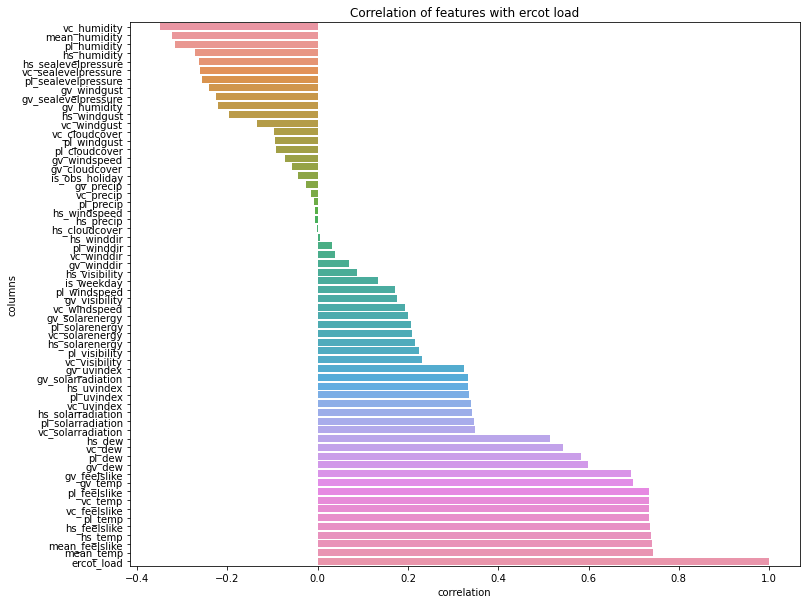

In [88]:
correlation = pd.DataFrame()
correlation['columns'] = train.corrwith(train['ercot_load'],method='spearman').index
correlation['correlation'] = train.corrwith(train['ercot_load'],method='spearman').values
sns.barplot(data=correlation.sort_values('correlation'), x='correlation', y='columns')
plt.title('Correlation of features with ercot load')
plt.show()

In [89]:
pd.set_option('display.max_rows', None)
train.corrwith(train['ercot_load'],method='spearman').sort_values(ascending=False).head()

ercot_load        1.000000
mean_temp         0.743809
mean_feelslike    0.741205
hs_temp           0.738962
hs_feelslike      0.737025
dtype: float64

**Notes:** 
- The strongest **positive** correlation between ercot load occurs with mean_temp, and mean_feelslike. **(~.74)**
- The strongest **negative** correlation between ercot load occurs with vc_humidity, mean_humidity, and pl_humidity. **(~-.32)**


**Initial hypothesis testing to occur on temperature and feels like**

### Temperarure and ERCOT Load

In [90]:
def plot_temp_ercot():
    sns.scatterplot(data=train, x='mean_temp',y='ercot_load')
    plt.axvline(x=(50),color='black',ls='--')
    plt.axvline(x=(70),color='black',ls='--')
    plt.title("ERCOT Load and Mean Temperature")
    plt.show()

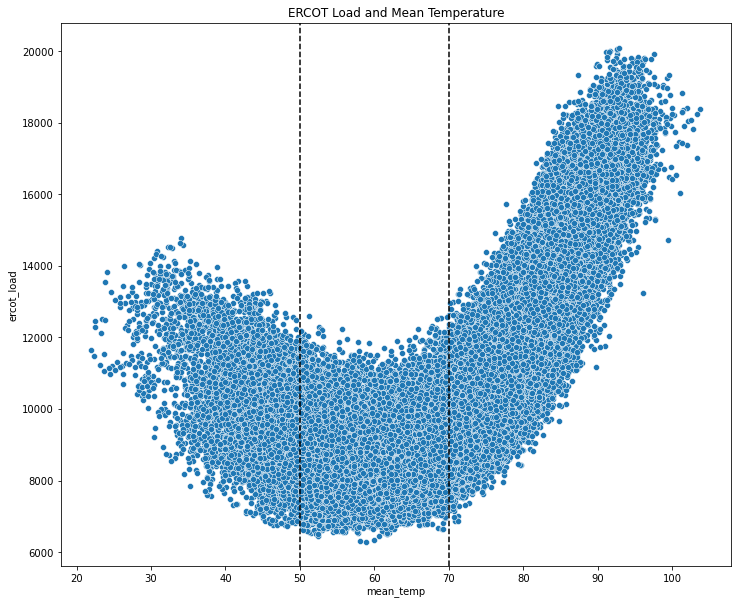

In [91]:
plot_temp_ercot()

### Hypothesis Testing

- Null Hypothesis: There is no relationship between ercot load and temperature.
- Alternative Hypothesis: There is a relationship between ercot load and temperature.

In [92]:
def temp_subgroups():
    less_50 = train[train.mean_temp <=50]
    mid_temp = train[(train.mean_temp>50)& (train.mean_temp<70)]
    greater_70 = train[train.mean_temp >=70]
    return less_50, mid_temp, greater_70

In [93]:
less_50, mid_temp, greater_70 = temp_subgroups()

In [94]:
r, p = stats.spearmanr(greater_70.ercot_load, greater_70.mean_temp)
r, p

(0.8273795989163407, 0.0)

In [95]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [96]:
r, p = stats.spearmanr(mid_temp.ercot_load, mid_temp.mean_temp)
r, p

(0.07272942335979242, 9.462527286479247e-28)

In [97]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [98]:
r, p = stats.spearmanr(less_50.ercot_load, less_50.mean_temp)
r, p

(-0.43770741903723387, 3.559188791408997e-287)

In [99]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [100]:
def plot_mean_temp():
    plt.subplot(131)
    g=sns.regplot(data=less_50, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
    plt.title('Less than 50 Degrees')
    g.set_ylim(6000, 22000)

    plt.subplot(132)
    g=sns.regplot(data=mid_temp, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
    plt.title('Between 50 and 70 Degrees')
    g.set_ylim(6000, 22000)
    g.set(yticklabels=[])
    g.set(ylabel=None)

    plt.subplot(133)
    g=sns.regplot(data=greater_70, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
    plt.title('Greater than 70 Degrees')
    g.set_ylim(6000, 22000)
    g.set(yticklabels=[])
    g.set(ylabel=None)
    plt.show()

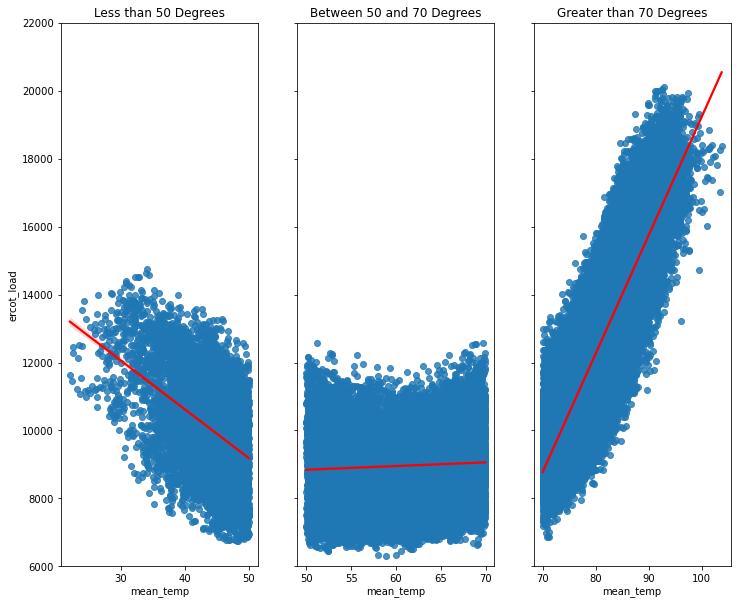

In [101]:
plot_mean_temp()

**Notes:** We can visually see the relationship between temperature like and ERCOT load, depicted by the U shape. To further test this relationship we performed hypothesis testing. Since Spearman's correlation assumes monotonic relationships, we divided the temperatures into three different ranges.

- Less than 50 degrees
- Between 50 and 70 degrees
- Greater than 70 degrees

The strongest relationship between temperature and ERCOT load is when it is greater than 70 degrees with a correlation coefficient of .83. There is a moderate negative relationship between temperatures that are less than 50 degress with a correlation coefficient of -.44. While, the mid-range temperatures are not as strongly correlated, all three ranges of temperatures are related to ERCOT load in regards to statistical significance.

### Feels like and ERCOT Load

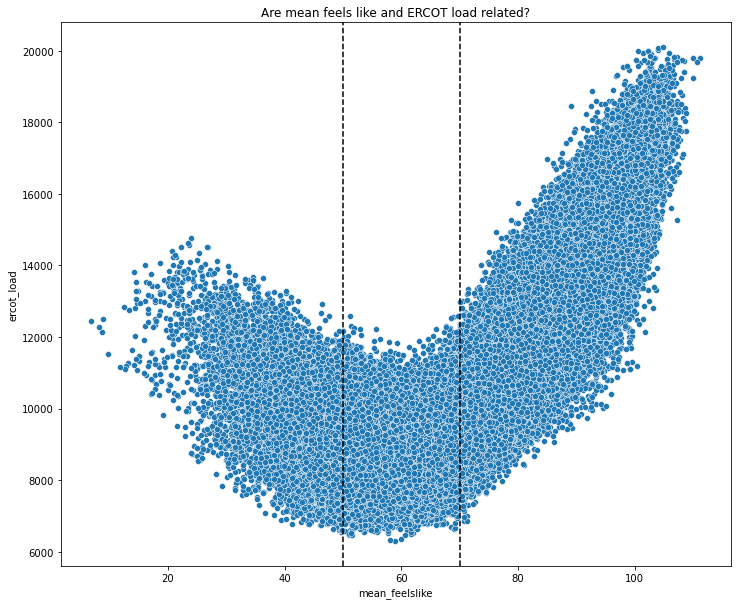

In [102]:
sns.scatterplot(data=train, x='mean_feelslike',y='ercot_load')
plt.title("Are mean feels like and ERCOT load related?")
plt.axvline(x=(50),color='black',ls='--')
plt.axvline(x=(70),color='black',ls='--')
plt.show()

In [103]:
less_50 = train[train.mean_feelslike<=50]
mid_feelslike= train[(train.mean_feelslike>50)& (train.mean_feelslike<70)]
greater_70 = train[train.mean_feelslike>=70]

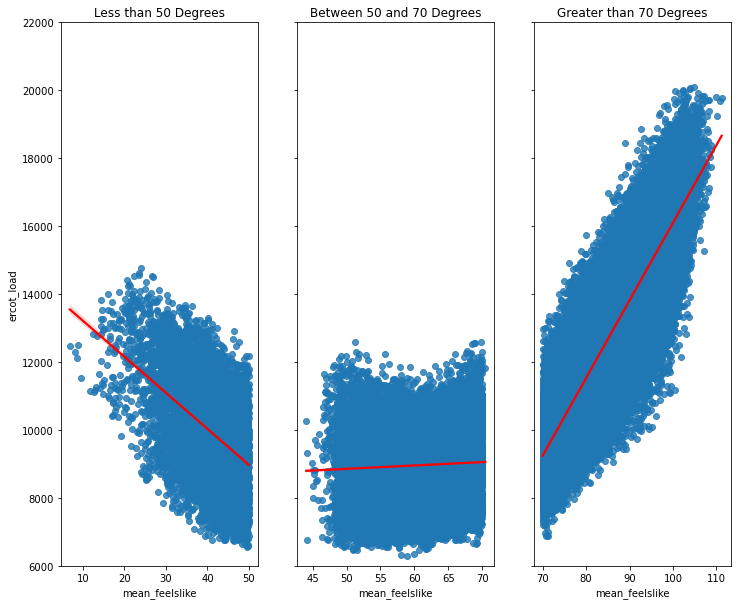

In [104]:
plt.subplot(131)
g=sns.regplot(data=less_50, x='mean_feelslike',y='ercot_load',line_kws={'color':'red'})
plt.title('Less than 50 Degrees')
g.set_ylim(6000, 22000)

plt.subplot(132)
g=sns.regplot(data=mid_temp, x='mean_feelslike',y='ercot_load',line_kws={'color':'red'})
plt.title('Between 50 and 70 Degrees')
g.set_ylim(6000, 22000)
g.set(yticklabels=[])
g.set(ylabel=None)

plt.subplot(133)
g=sns.regplot(data=greater_70, x='mean_feelslike',y='ercot_load',line_kws={'color':'red'})
plt.title('Greater than 70 Degrees')
g.set_ylim(6000, 22000)
g.set(yticklabels=[])
g.set(ylabel=None)
plt.show()

### Hypothesis Testing

- Null Hypothesis: There is no relationship between ercot load and mean feels like.
- Alternative Hypothesis: There is a relationship between ercot load and mean feels like.

In [105]:
r, p = stats.spearmanr(greater_70.ercot_load, greater_70.mean_feelslike)
r, p

(0.8175146840379727, 0.0)

In [106]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [107]:
r, p = stats.spearmanr(mid_feelslike.ercot_load, mid_feelslike.mean_feelslike)
r, p

(0.08289328205452048, 1.521342834954172e-34)

In [108]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [109]:
r, p = stats.spearmanr(less_50.ercot_load, less_50.mean_feelslike)
r, p

(-0.461010195441998, 0.0)

In [110]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


**Notes:** We can visually see the relationship between mean feels like and ERCOT load, depicted by the U shape. To further test this, we ran Spearman's correlation testing with three different ranges of feels like temperatures. 

- Less than 50 degrees
- Between 50 and 70 degrees
- Greater than 70 degrees

The strongest relationship between feels like and ERCOT load is when it feels like greater than 70 degrees with a correlation coefficient of .82. There is a moderate negative relationship between temperatures that fee like less than 50 degress with a correlation coefficient of -.46. While, the mid-range feels like temperatures are not as strongly correlated, all three ranges of temperatures are related to ERCOT load in regards to statistical significance.

### Humidity and ERCOT LOAD

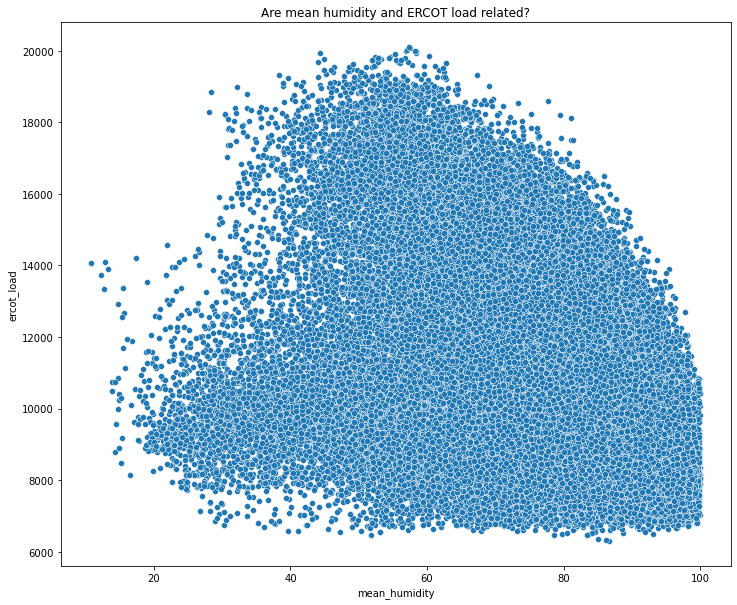

In [111]:
sns.scatterplot(data=train, x='mean_humidity',y='ercot_load')
plt.title("Are mean humidity and ERCOT load related?")
plt.show()

### Hypothesis Testing

- Null Hypothesis: There is no relationship between ercot load and humidity.
- Alternative Hypothesis: There is a relationship between ercot load and humidity.

In [112]:
r, p = stats.spearmanr(train.ercot_load, train.mean_humidity)
r, p

(-0.32305121261403674, 0.0)

In [113]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.
